In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *

# Align IMU

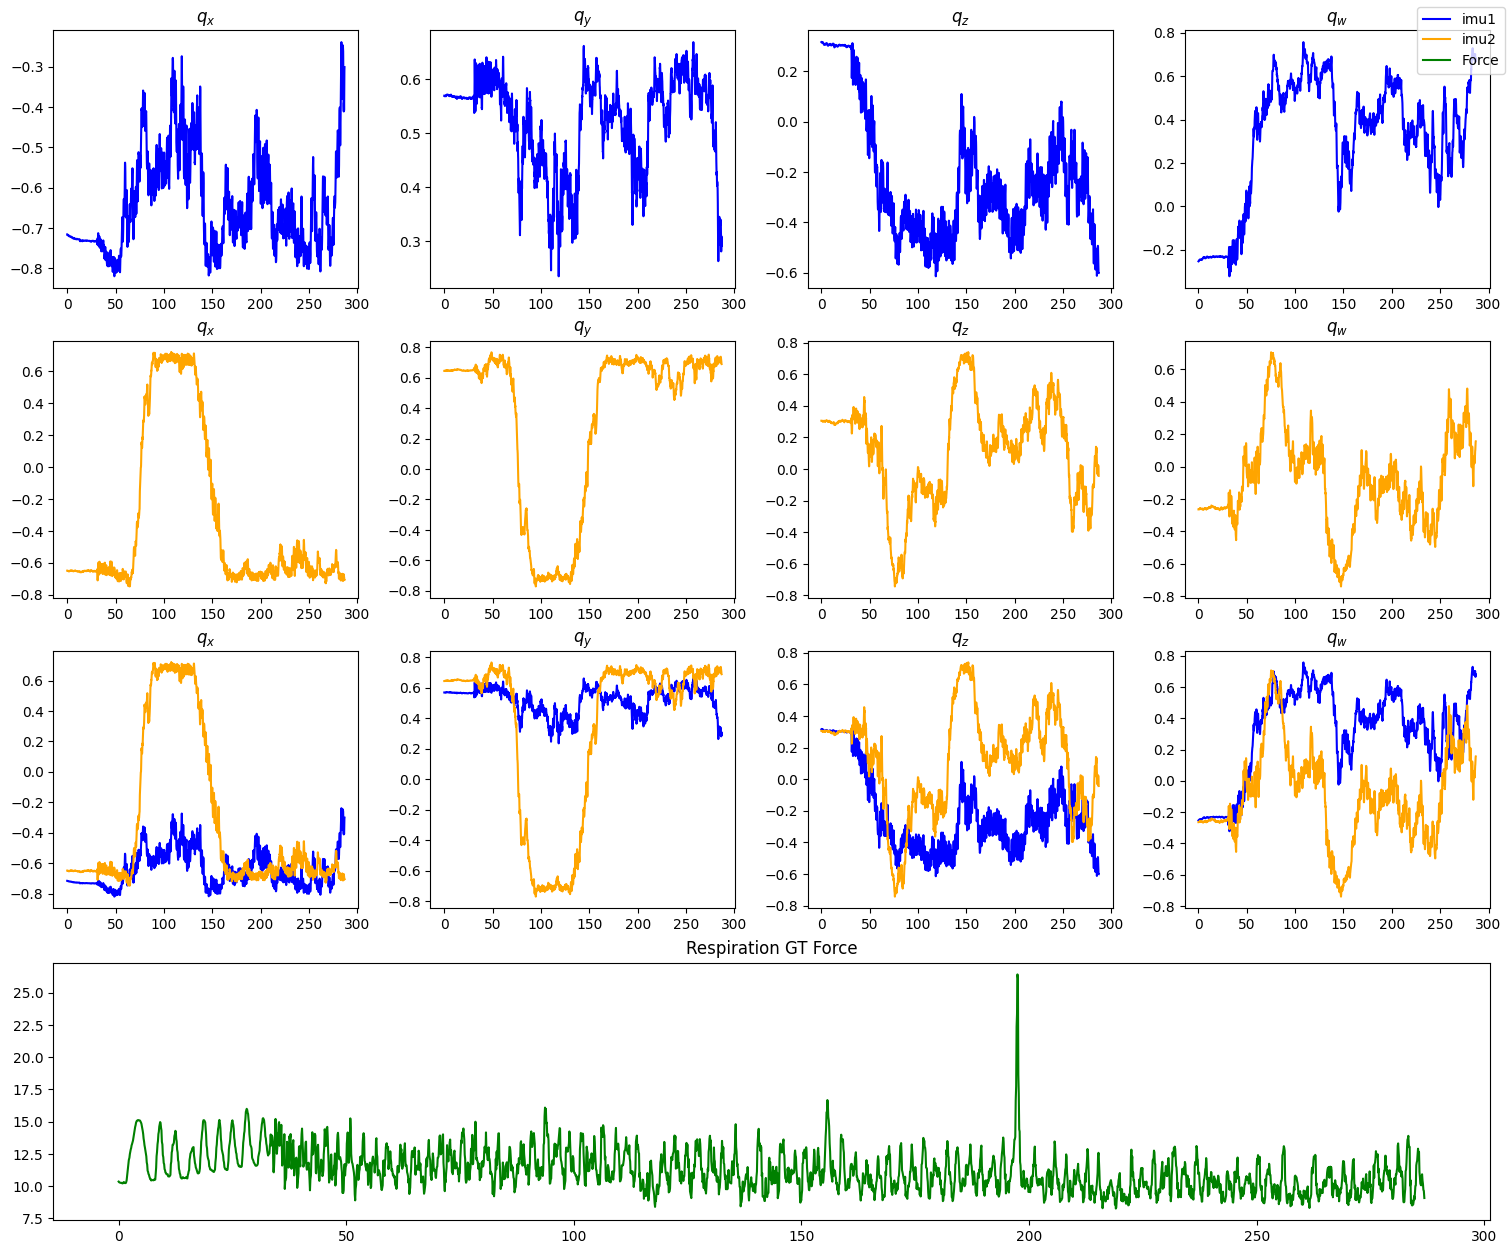

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

action_name = "walk_stand_0407_0852" # sit_0407_0746, stand_0407_0816, walk_stand_0407_0852, walk_stand_0407_0858
file_path = f'./data/2P/test/{action_name}.csv'

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

In [3]:
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

best_score/total: 300/300


In [4]:
target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

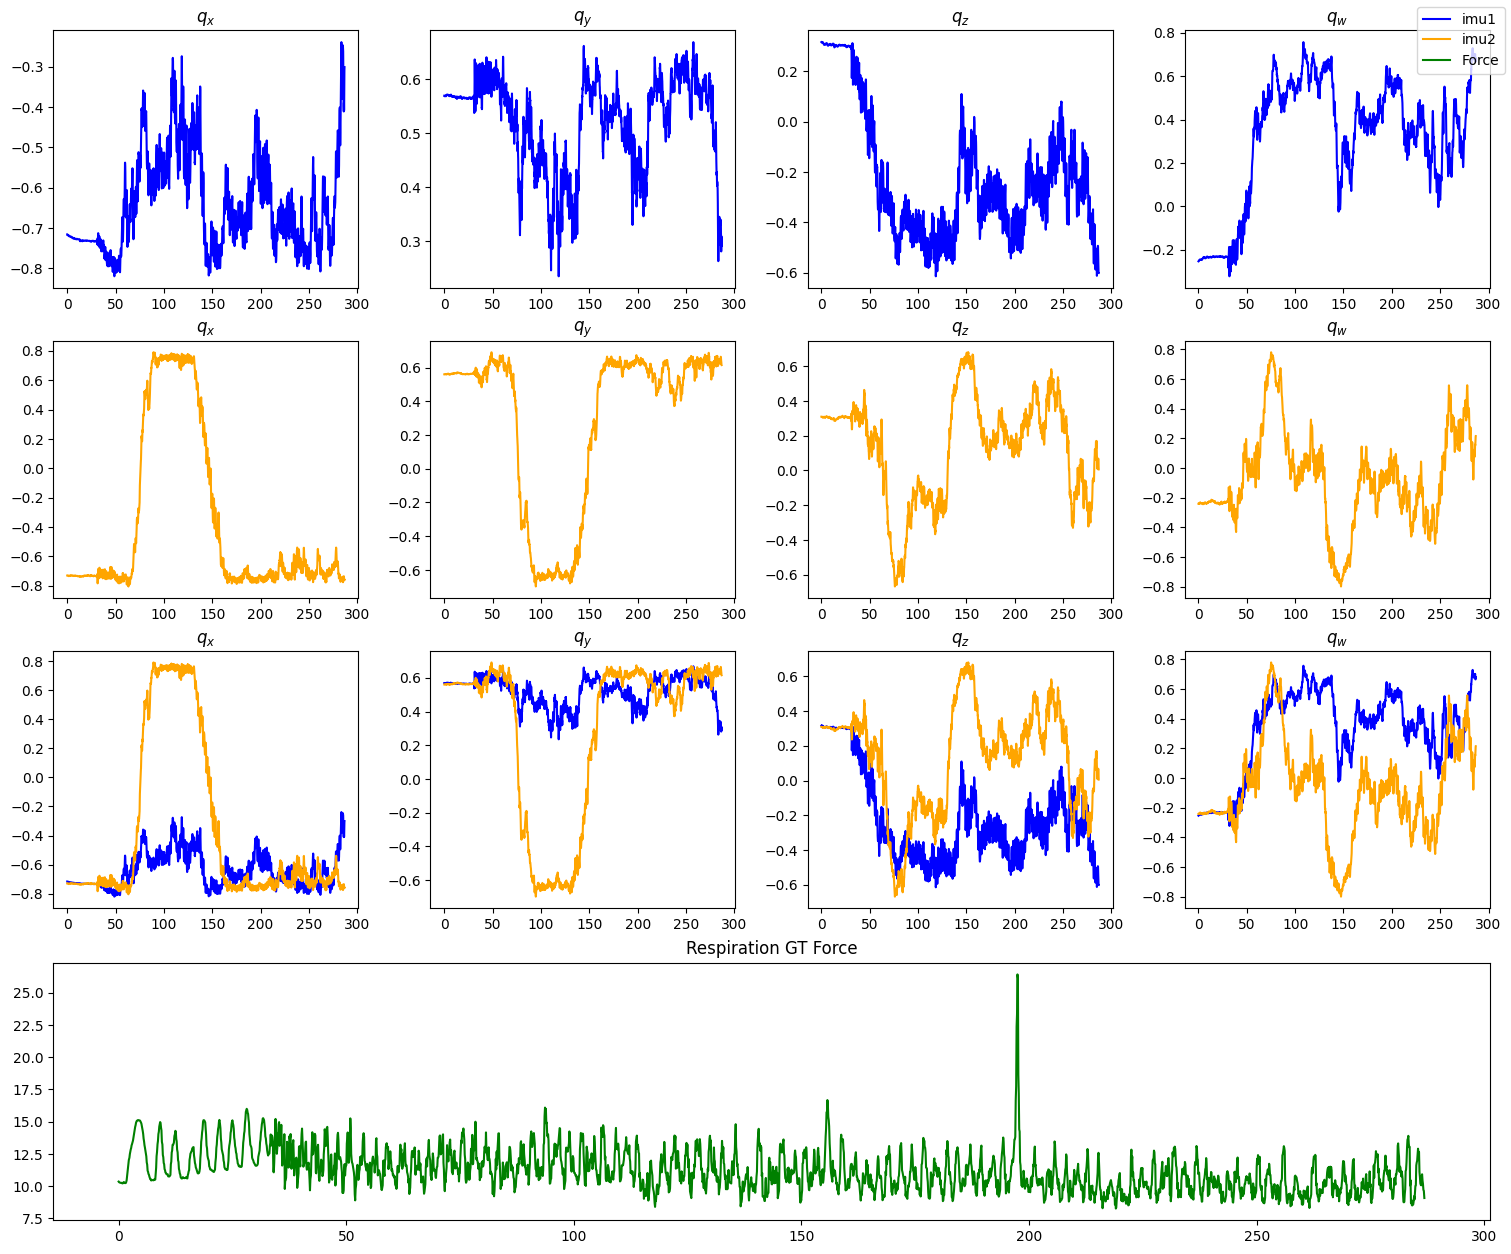

In [5]:
draw_imu_curve(data_aligned, overlap=True, show_gt=True)
# draw_imu_curve(data_aligned, overlap=True, show_gt=False)

# ANC

In [6]:
# Parameters
ntaps_value = 10  # 45, 45, 5, 10
learning_rate_value = 0.0005 # 0.001, 0.005, 0.005, 0.0005
delta_value = 100 # 0.001, 0.001, 100
lam_rls_value = 0.995  # 0.98, 0.98, 0.995
lam_lrls_value = 0.99  # 0.99, 0.99, 0.99

In [7]:
data_anc = data_aligned # data used in anc
data_anc = data_anc[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion
# cols = ['u', 'v', 'w'] # for euler angle

# data_anc.loc[:, "Force"] = butter_filter(data_anc["Force"], cutoff=0.66)

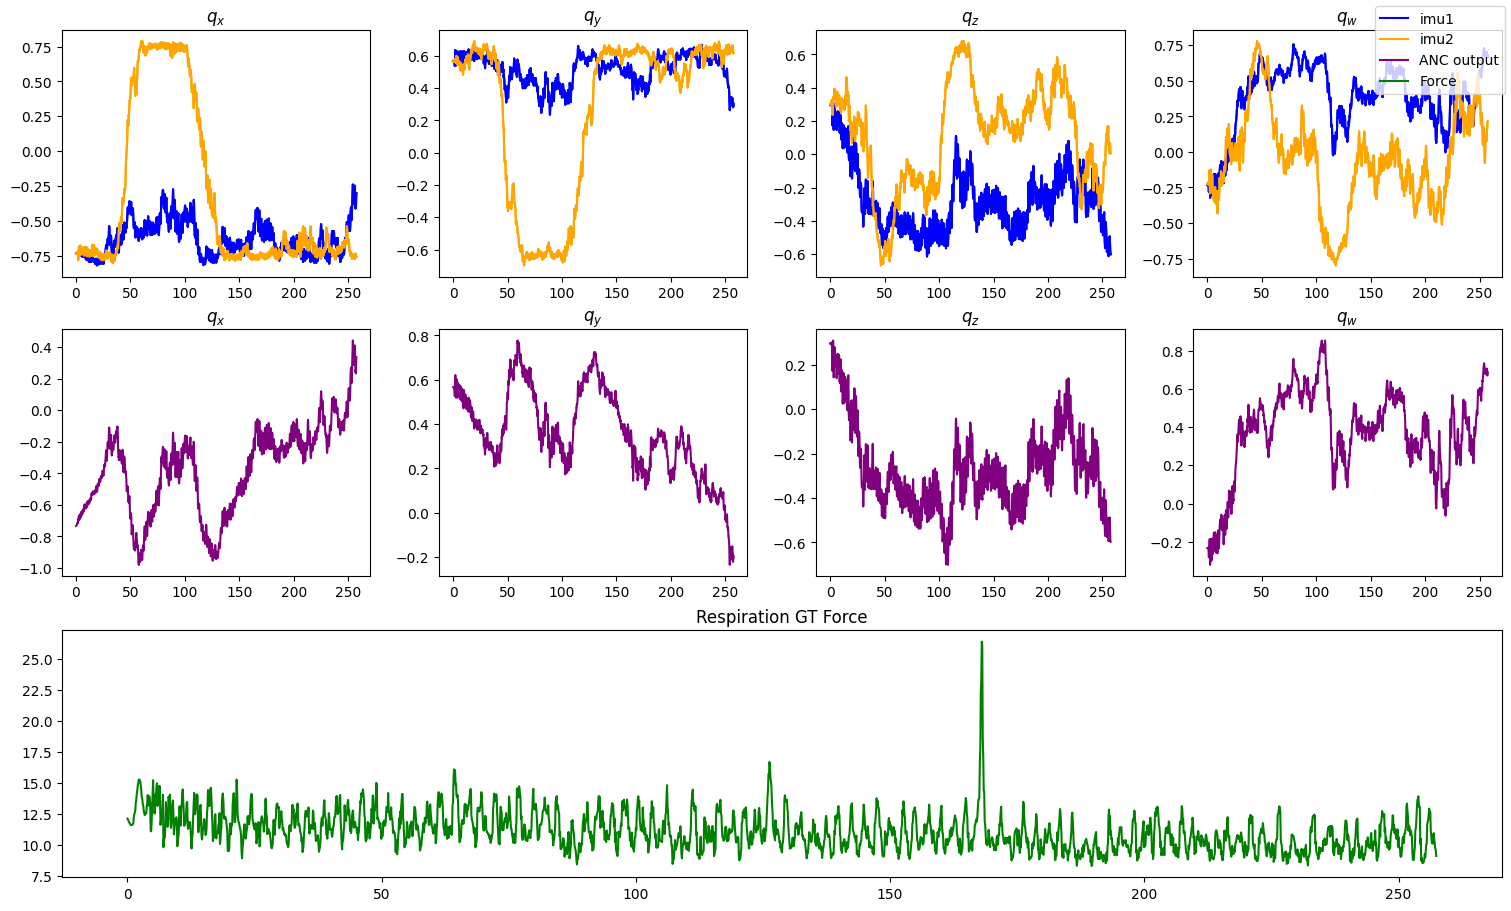

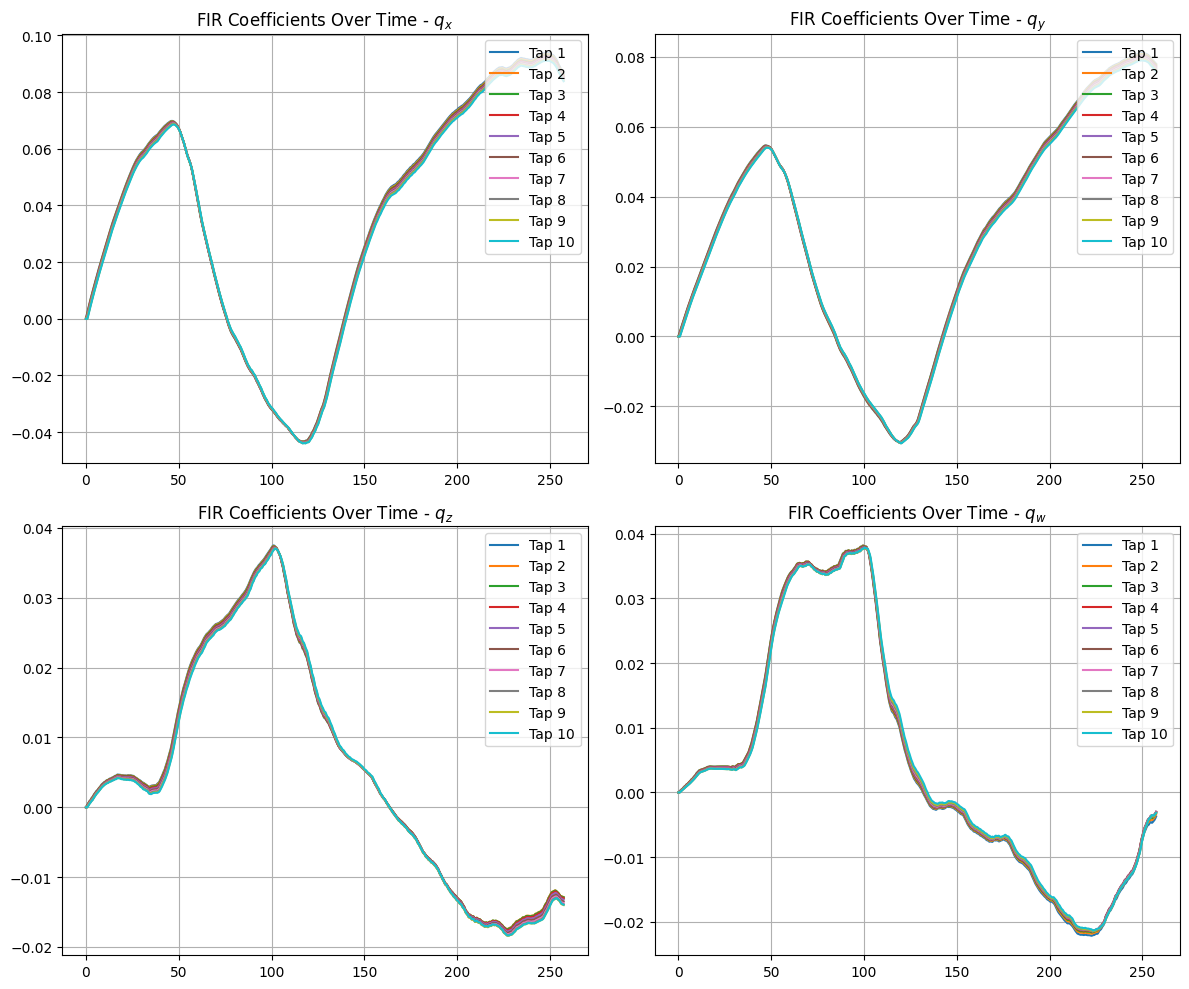

In [8]:
NTAPS = ntaps_value
LEARNING_RATE = learning_rate_value

outputs_dict_LMS = {}
outputs_dict_LMS['method'] = 'LMS'
coefficients_dict_LMS = {}
coefficients_dict_LMS['method'] = 'LMS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMS[col] = y
    coefficients_dict_LMS[col] = coefficients_history

draw_anc_curve(data_anc, outputs=outputs_dict_LMS)
draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMS)

LEARNING_RATE:0.009786401291838427
LEARNING_RATE:0.008736971804254616
LEARNING_RATE:0.0036986429548520523
LEARNING_RATE:0.008481120758116597


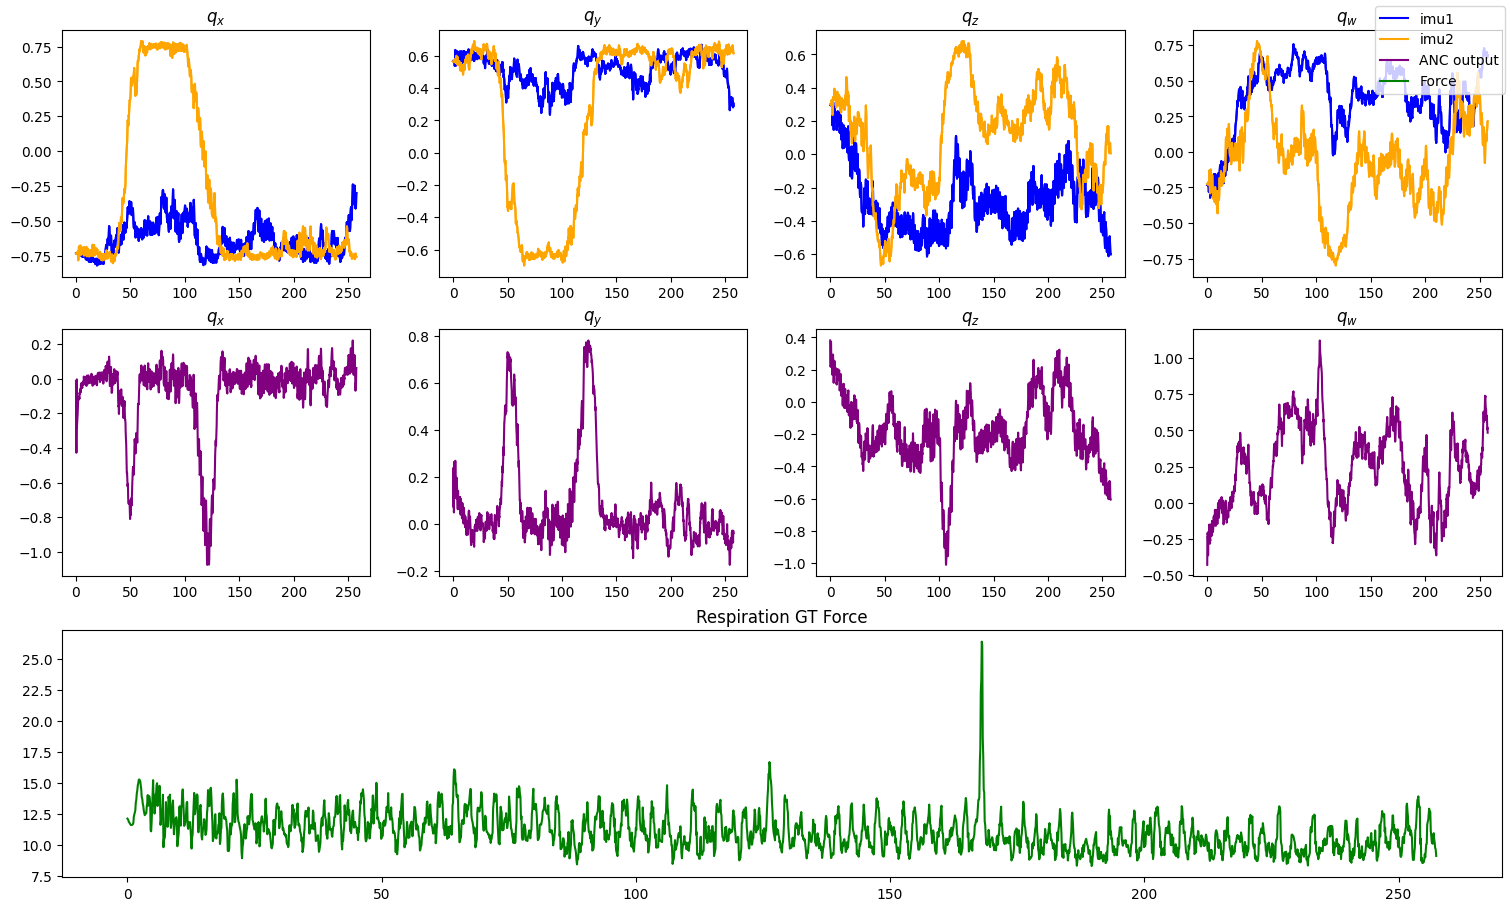

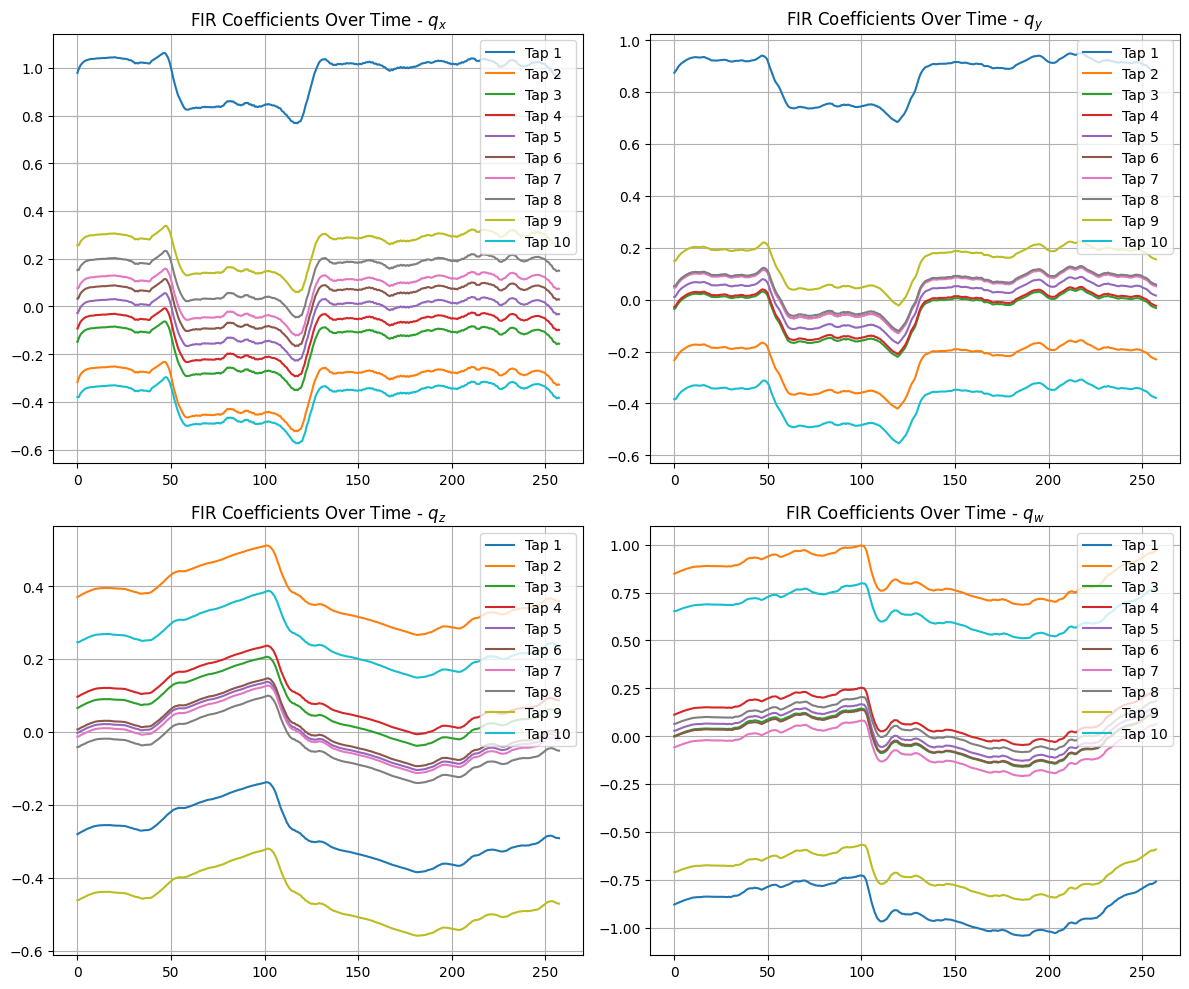

In [9]:
outputs_dict_LMSLS = {}
outputs_dict_LMSLS['method'] = 'LMS+LS'
coefficients_dict_LMSLS = {}
coefficients_dict_LMSLS['method'] = 'LMS+LS'
for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))

    # Least Square Once
    f.ls(x, d)
    LEARNING_RATE = np.max(f.coefficients) / 100 # / 100
    print(f'LEARNING_RATE:{LEARNING_RATE}')
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.lms(output_signal, LEARNING_RATE)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_LMSLS[col] = y
    coefficients_dict_LMSLS[col] = coefficients_history

draw_anc_curve(data_anc, outputs=outputs_dict_LMSLS)
draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_LMSLS)

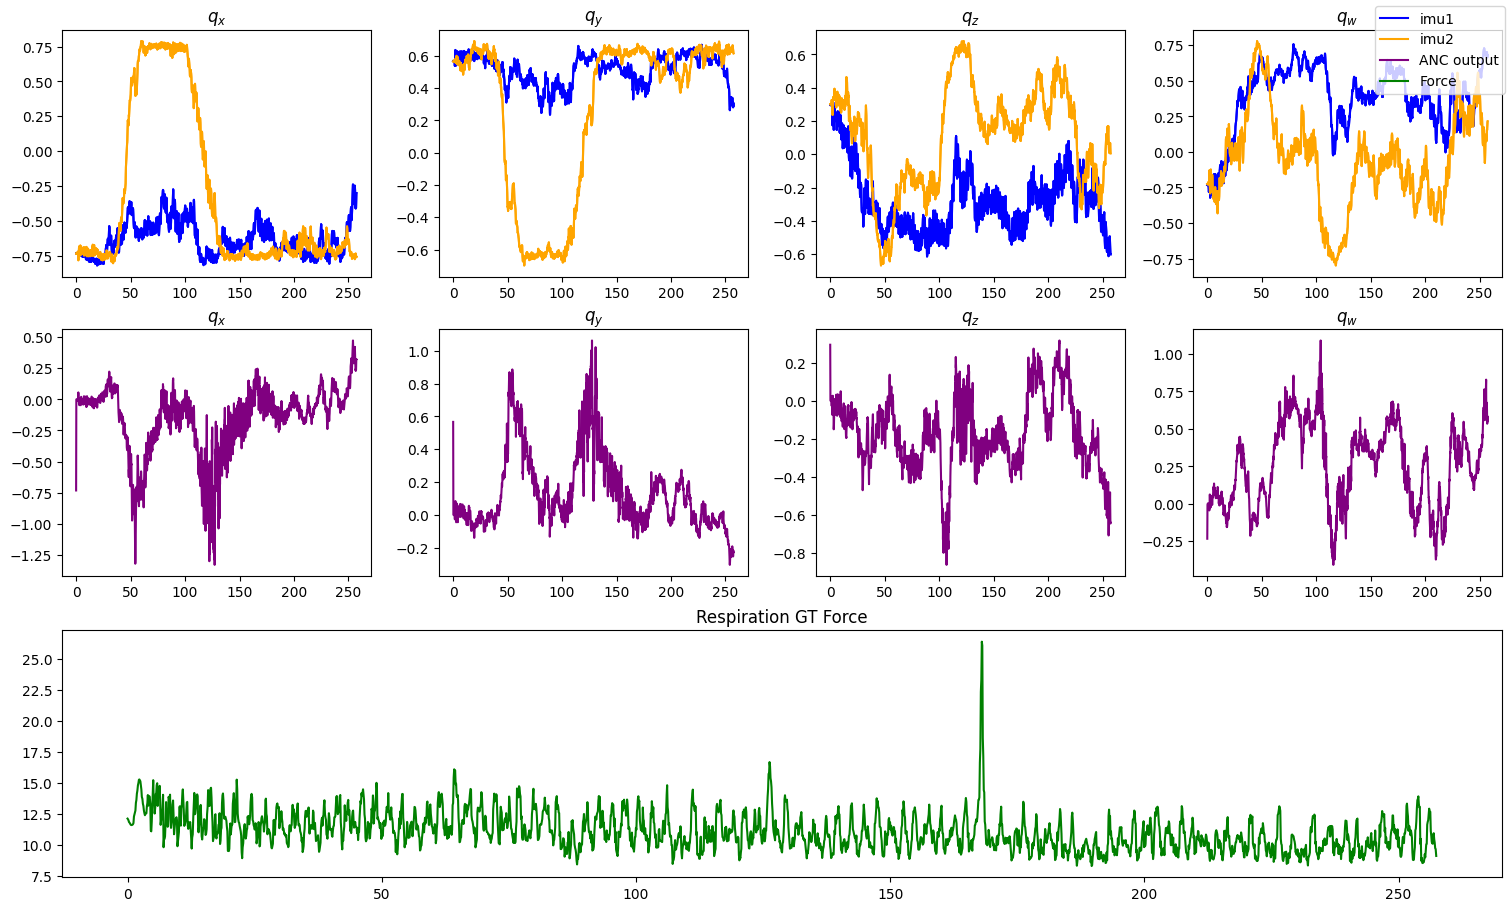

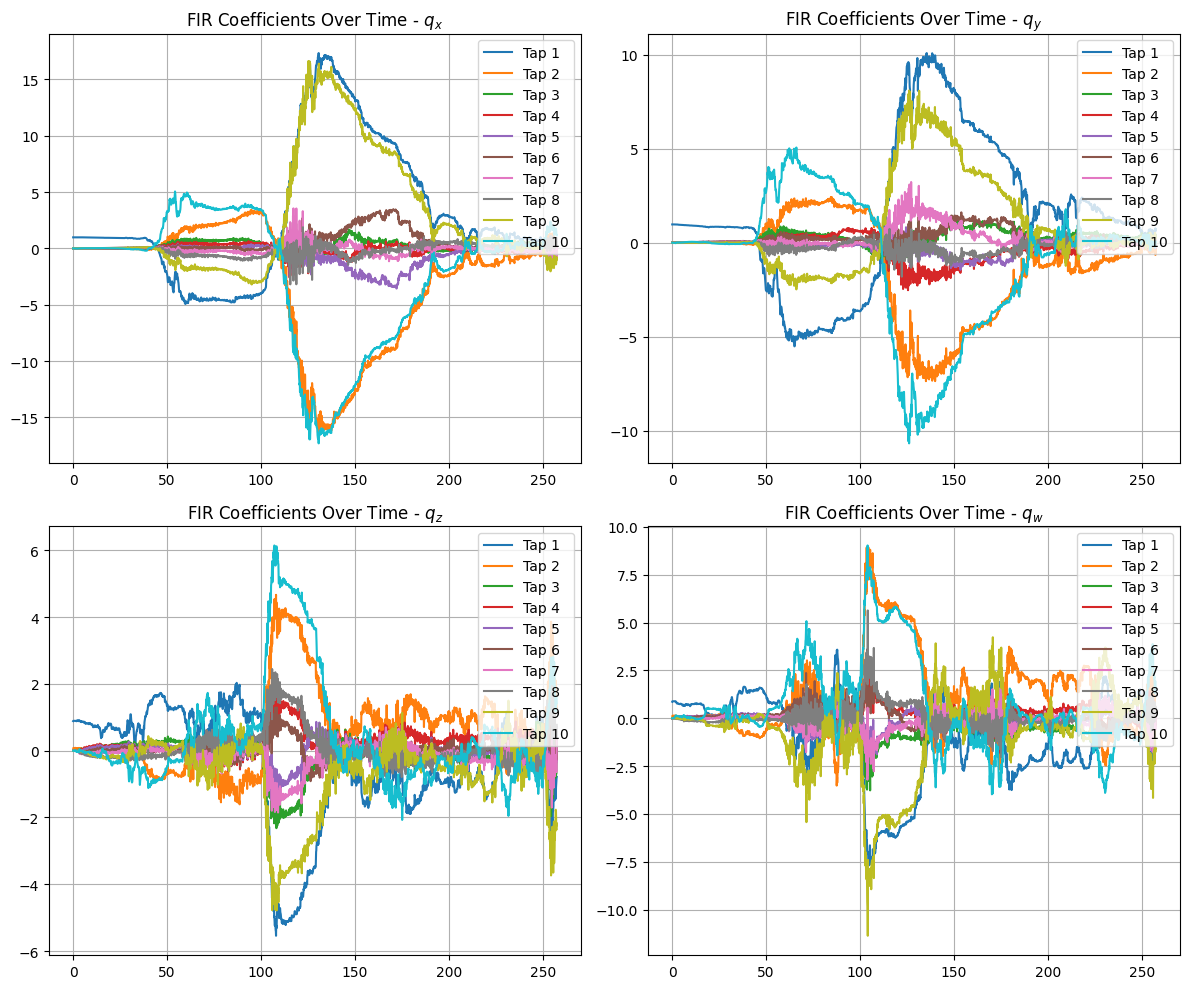

In [10]:
outputs_dict_RLS = {}
outputs_dict_RLS['method'] = 'RLS'
coefficients_dict_RLS = {}
coefficients_dict_RLS['method'] = 'RLS'

# RLS
delta = delta_value
lam_rls = lam_rls_value

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        canceller = f.filter(ref_noise)
        output_signal = d[i] - canceller
        f.rls(output_signal, delta=delta, lam=lam_rls)
        coefficients_history[i] = f.coefficients
        y[i] = output_signal
    
    outputs_dict_RLS[col] = y
    coefficients_dict_RLS[col] = coefficients_history

draw_anc_curve(data_anc, outputs=outputs_dict_RLS)
draw_fir_coefficients_curve(data_anc, coefficients=coefficients_dict_RLS)

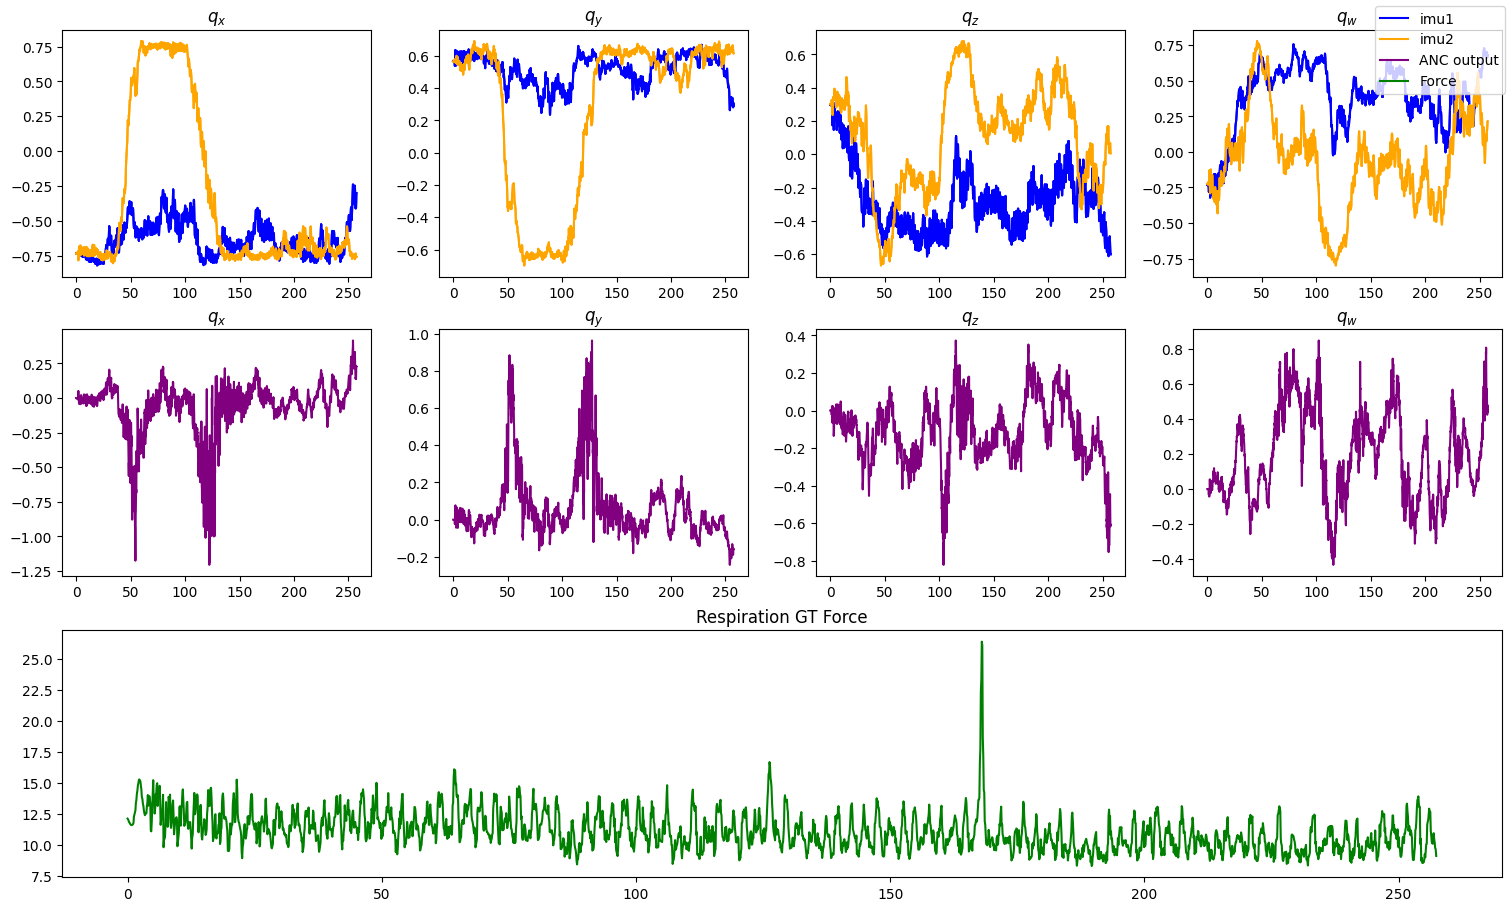

In [11]:
outputs_dict_LRLS = {}
outputs_dict_LRLS['method'] = 'LRLS'

# LRLS
epsilon = 1e-6
lam_lrls = lam_lrls_value

for col in cols:
    d = data_anc[sensor_names[0] + '_' + col].to_numpy() # IMU1 (desire signal with more RR info.)
    x = data_anc[sensor_names[1] + '_' + col].to_numpy() # IMU2 (reference noise)
    f = FIR_filter(np.zeros(NTAPS))
    y = np.empty(len(d))

    coefficients_history = np.empty((len(d), NTAPS))
    
    # DO FIR filter
    for i in range((len(d))):
        ref_noise = x[i]
        output_signal = f.lrls(x=ref_noise, d=d[i], N= len(d), lam=lam_lrls)
        y[i] = output_signal
    
    outputs_dict_LRLS[col] = y

draw_anc_curve(data_anc, outputs=outputs_dict_LRLS)

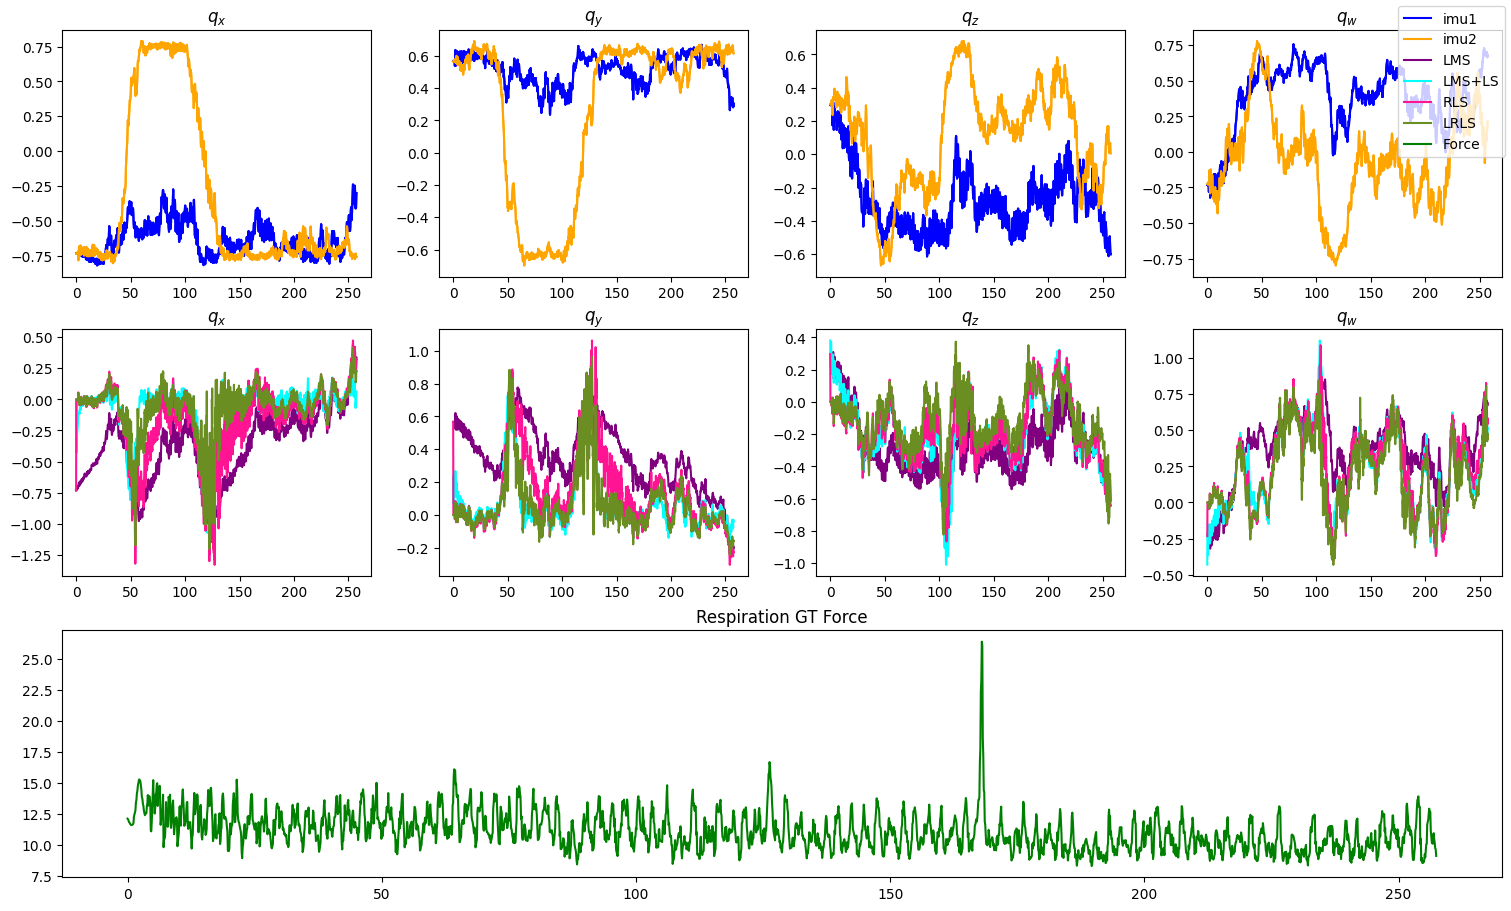

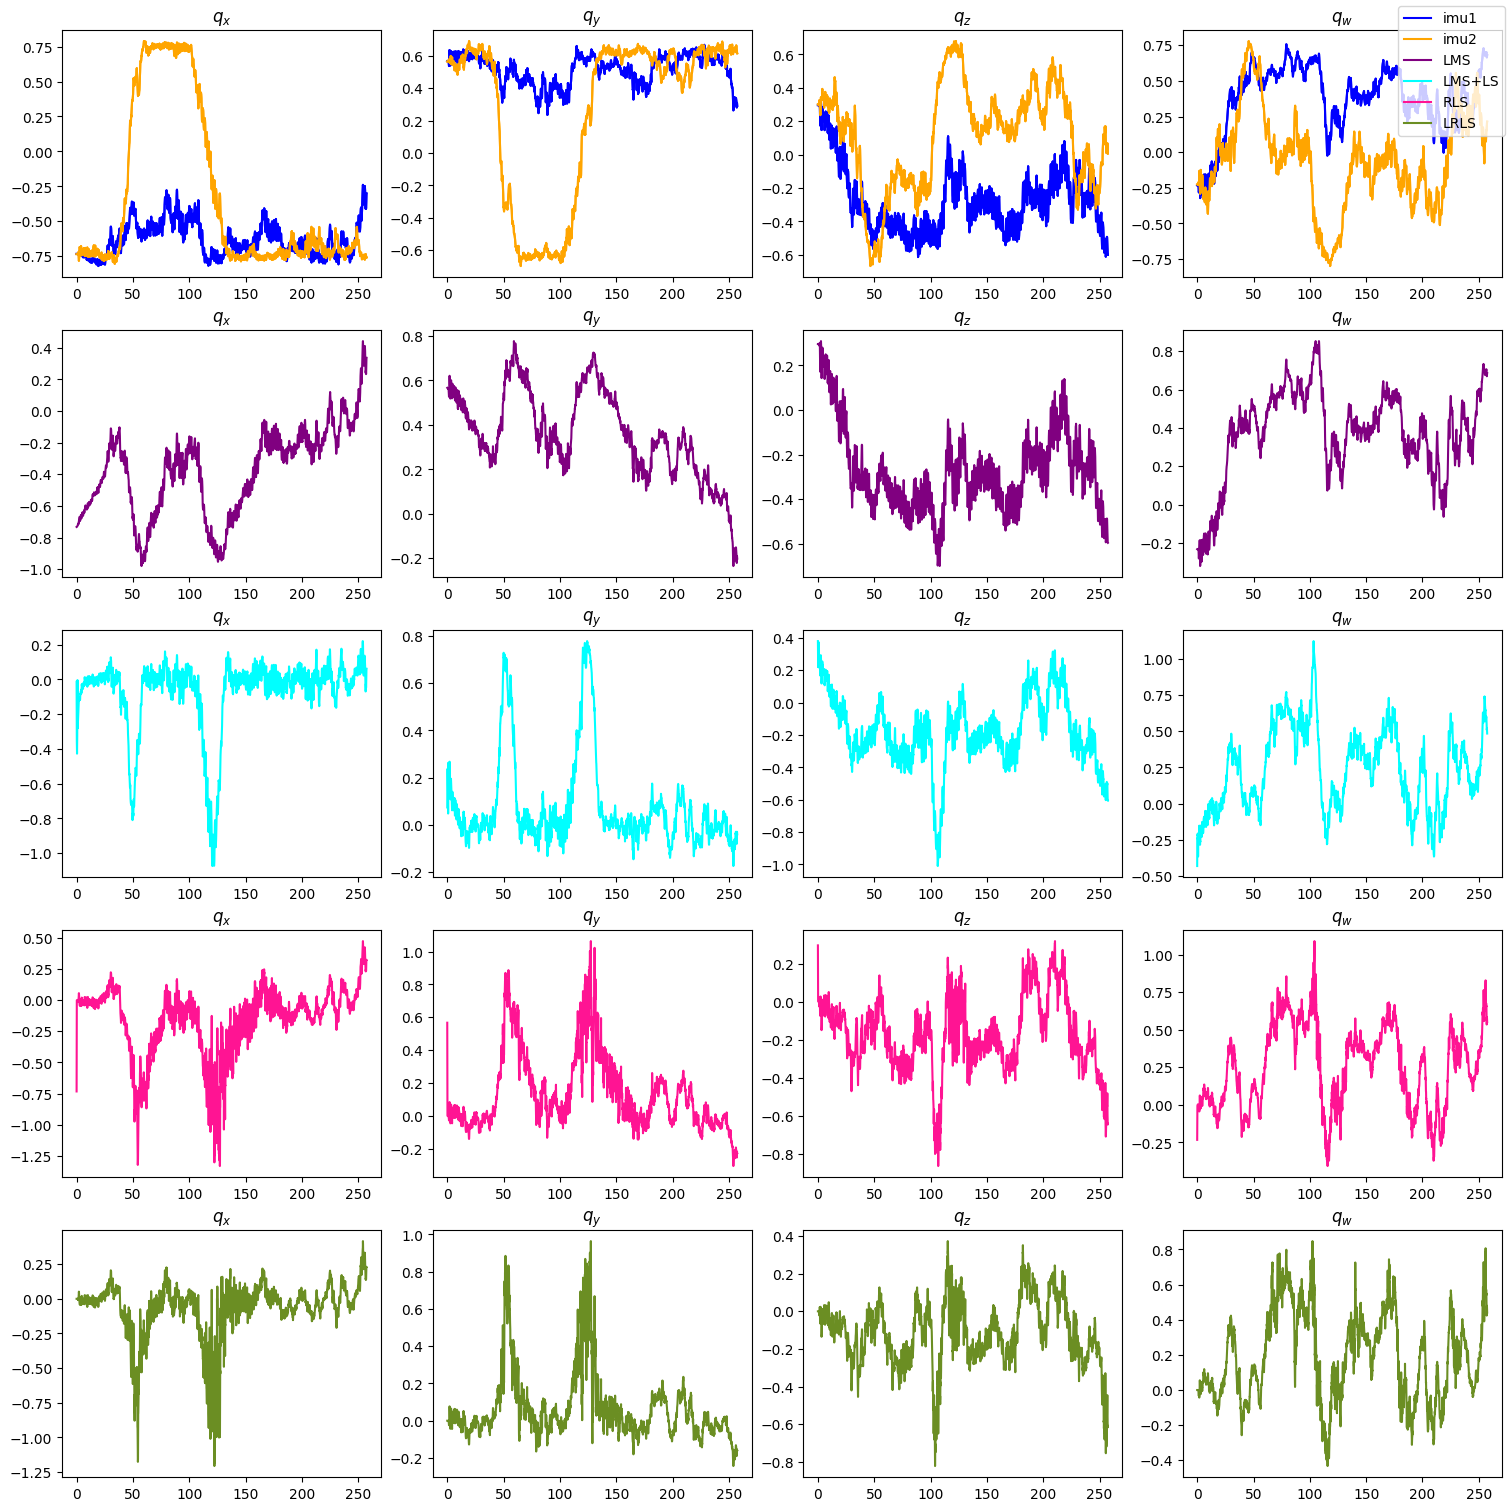

In [12]:
# Show all ANC results
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS])
draw_anc_curve_multi(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], overlap=False, show_gt=False)

# Auto-Correlation

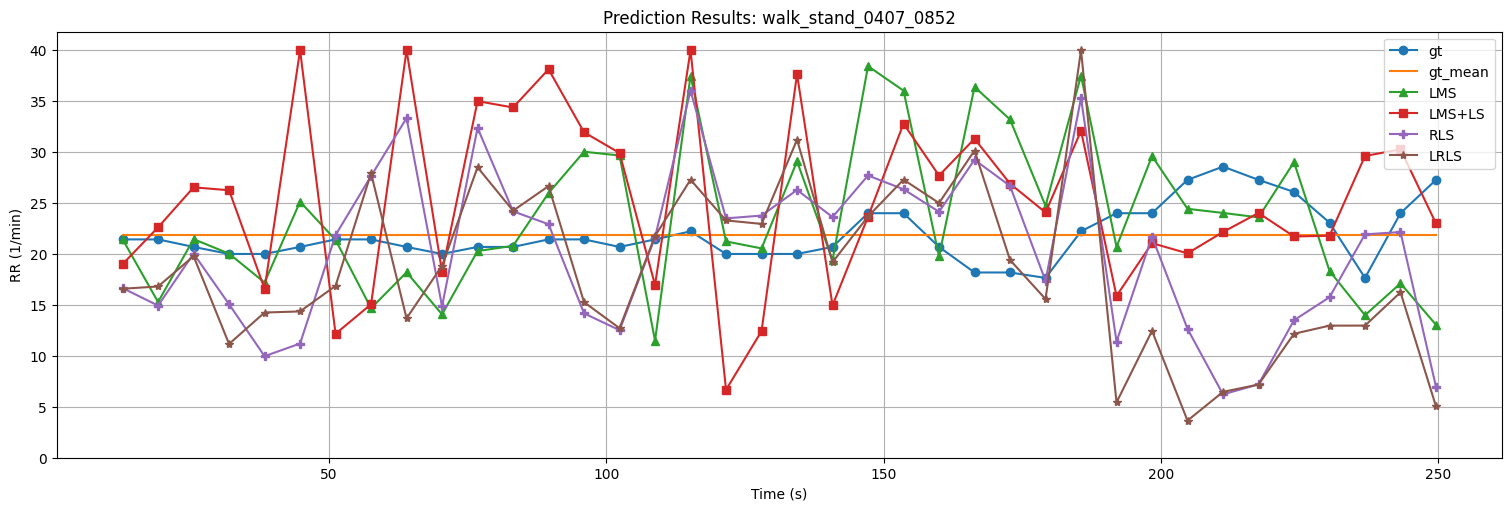

MAE:
LMS:13.3342
LMS+LS:14.1875
RLS:13.6987
LRLS:13.3543
R²:
LMS:-7.5620
LMS+LS:-12.5145
RLS:-11.4164
LRLS:-13.6932


In [14]:
# Auto Correlation
window = 25.6 # 12.8
overlap = 19.2 # 6.4
mae, r2 = auto_correlation(data_anc, outputs=[outputs_dict_LMS, outputs_dict_LMSLS, outputs_dict_RLS, outputs_dict_LRLS], window=window, overlap=overlap, visualize=True, action_name=action_name, return_r2=True)

print("MAE:")
for i, k in enumerate(mae):
    print(f'{k}:{mae[k]:.4f}')

print("R\u00b2:")
for i, k in enumerate(r2):
    print(f'{k}:{r2[k]:.4f}')